In [ ]:
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import os
import gensim
from gensim import corpora
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

###Data Loading

We load data from CSV and JSON files corresponding to different years using URLs. The DataFrames are then concatenated into a single DataFrame called combined_df. To ensure data quality, rows with missing values in the 'caption_text_clean' column are dropped. The resulting combined_df holds organized and cleaned data from various years for further analysis.

In [ ]:
csv_urls = [
    '6889547',  # 2006
    '6893130',  # 2007
    '6893115',  # 2008
    '6893092',  # 2009
    '6893082',  # 2010
    '6893107',  # 2011
    '6893081',  # 2012
    '6893103',  # 2013
    '6893137',  # 2014
    '6893062',  # 2015
    '6893122',  # 2016
    '6893135',  # 2019
    '6893119',  # 2020
    '6893097',  # 2021
    '6893076',  # 2022
]

# Create an empty list to store DataFrames for each year
dfs = []

# Loop through each CSV URL
year = 2006
for id in csv_urls:
    url = 'https://dataverse.harvard.edu/api/access/datafile/'+id
    response = requests.get(url)
    if response.status_code == 200:
        # Read and process the downloaded CSV content
        df = pd.read_csv(BytesIO(response.content))
        # Add a 'year' column with the current year
        df['year'] = year
        # Append the DataFrame to the list
        dfs.append(df)
    year += 1
    if year == 2017:
        year += 2

# Fetch the JSON data for 2017
response_2017 = requests.get('https://dataverse.harvard.edu/api/access/datafile/6893078')
if response_2017.status_code == 200:
    # Parse JSON data for 2017
    json_data_2017 = response_2017.json()

    # Convert the JSON data to a Pandas DataFrame
    json_df_2017 = pd.json_normalize(json_data_2017)
    json_df_2017['year'] = 2017
    dfs.append(json_df_2017)

# Fetch the JSON data for 2018
response_2018 = requests.get('https://dataverse.harvard.edu/api/access/datafile/6893045')
if response_2018.status_code == 200:
    # Parse JSON data for 2018
    json_data_2018 = response_2018.json()

    # Convert the JSON data to a Pandas DataFrame
    json_df_2018 = pd.json_normalize(json_data_2018)
    json_df_2018['year'] = 2018
    dfs.append(json_df_2018)

# Combine all the DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Drop rows with NaN values in the 'caption_text_clean' column
combined_df = combined_df.dropna(subset=['caption_text_clean'])

# Display the combined DataFrame
combined_df


st_fips state_name        place_name            place_govt  \
0       4841980      Texas  League City city     MUNICIPAL COUNCIL   
1       4841980      Texas  League City city     MUNICIPAL COUNCIL   
2       4841980      Texas  League City city     MUNICIPAL COUNCIL   
3       4841980      Texas  League City city     MUNICIPAL COUNCIL   
4       4841980      Texas  League City city     MUNICIPAL COUNCIL   
...         ...        ...               ...                   ...   
139611  5613150    Wyoming       Casper city     MUNICIPAL COUNCIL   
139612  5613150    Wyoming       Casper city     MUNICIPAL COUNCIL   
139613  5613150    Wyoming       Casper city     MUNICIPAL COUNCIL   
139614  5613150    Wyoming       Casper city     MUNICIPAL COUNCIL   
139615   158693        NaN               NaN  BOARD OF SUPERVISORS   

        place_Pres_dem2pv  place_Pres_dem2pv_last  place_Gov_dem2pv  \
0                     NaN                     NaN               NaN   
1                     NaN                     NaN               NaN   
2                     NaN                     NaN               NaN   
3                     NaN                     NaN               NaN   
4                     NaN                     NaN               NaN   
...                   ...                     ...               ...   
139611                NaN                  0.2185            0.2737   
139612                NaN                  0.2185            0.2737   
139613                NaN                  0.2185            0.2737   
139614                NaN                  0.2185            0.2737   
139615                NaN                     NaN               NaN   

        place_Gov_dem2pv_last  place_House_dem2pv  place_House_dem2pv_last  \
0                         NaN                 NaN                      NaN   
1                         NaN                 NaN                      NaN   
2                         NaN                 NaN                      NaN   
3                         NaN                 NaN                      NaN   
4                         NaN                 NaN                      NaN   
...                       ...                 ...                      ...   
139611                 0.2737               0.303                    0.303   
139612                 0.2737               0.303                    0.303   
139613                 0.2737               0.303                    0.303   
139614                 0.2737               0.303                    0.303   
139615                    NaN                 NaN                      NaN   

        ...  vid_views  vid_likes vid_dislikes  vid_comments  vid_favorites  \
0       ...        8.0        0.0          0.0           0.0              0   
1       ...       12.0        0.0          0.0           0.0              0   
2       ...        8.0        0.0          0.0           0.0              0   
3       ...        0.0        0.0          0.0           0.0              0   
4       ...        2.0        0.0          0.0           0.0              0   
...     ...        ...        ...          ...           ...            ...   
139611  ...      190.0        NaN          NaN           NaN              0   
139612  ...       44.0        NaN          NaN           NaN              0   
139613  ...      164.0        NaN          NaN           NaN              0   
139614  ...       99.0        NaN          NaN           NaN              0   
139615  ...       65.0        2.0          0.0           0.0              0   

        meeting_date                                       caption_text  \
0         2006-11-14  {00:00:21} tell me when okay fellas were up go...   
1         2006-10-24  {00:00:24} alright alright let's welcome every...   
2         2006-12-12  {00:00:41} Your Honor okay good afternoon will...   
3         2006-11-28  {00:00:28} okay good afternoon we will call th...   
4         2006-10-10  {00:00:32} okay we're up good a

In [ ]:
# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined_data.csv', index=False)


### Preprocess

#### Clean Text

We use pandas and regular expressions to clean and preprocess the text in a DataFrame. We converts text to lowercase, expands contractions, removes possessive markers, replaces specific patterns, removes punctuation, leading/trailing spaces, and common stop words. The result is a cleaned DataFrame ready for analysis:

In [ ]:
# Define the clean_text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\'ve", ' have', text)
    text = re.sub(r"\'ll", ' will', text)
    text = re.sub(r"in'", 'ing', text)
    text = re.sub(r"won't", 'will not', text)
    text = re.sub(r"i'm", 'i am', text)
    text = re.sub(r"he's", 'he is', text)
    text = re.sub(r"she's", 'she is', text)
    text = re.sub(r"it's", 'it is', text)
    text = re.sub(r"we're", 'we are', text)
    text = re.sub(r"you're", 'you are', text)
    text = re.sub(r"they're", 'they are', text)
    text = re.sub(r"who'se", 'who is', text)
    text = re.sub(r"who're", 'who are', text)
    text = re.sub(r"what's", 'what is', text)
    text = re.sub(r"where's", 'where is', text)
    text = re.sub(r"y'all", 'you all', text)
    text = re.sub(r"\'d", ' would', text)
    text = re.sub(r"ain't", 'are not', text)
    text = re.sub(r"can't", 'can not', text)
    text = re.sub(r"evry", 'every', text)
    text = re.sub(r"n't", 'not', text)
    text = re.sub(r"\'s", '', text)
    text = re.sub(r"\'", '', text)
    text = re.sub(r"hasnot", 'has not', text)
    text = re.sub(r"doesnot", 'does not', text)
    text = re.sub(r"couldnot", 'could not', text)
    text = re.sub(r"wouldnot", 'would not', text)
    text = re.sub(r"isnot", 'is not', text)
    text = re.sub(r"havenot", 'have not', text)
    text = re.sub(r"shouldnot", 'have not', text)
    text = re.sub(r"donot", 'do not', text)
    text = re.sub(r"arenot", 'are not', text)
    text = re.sub(r"wasnot", 'was not', text)
    text = re.sub(r"&", 'endline', text)
    # Remove punctuations
    punctuations = r"""!"#$%()*+,-./:;<=>?@[\]^_`{|}~"""
    text = text.translate(str.maketrans(punctuations, ' ' * len(punctuations)))

    # Replace some specific patterns with desired words (e.g., "&" with "endline")
    text = re.sub(r"&", 'endline', text)
    return text

def remove_stopword(text):
  stop_words = stopwords.words('english')
  stopwords_dict = Counter(stop_words)
  text = ' '.join([word for word in text.split() if word not in stopwords_dict])
  return text

def remove_spaces(text):
    text=text.strip()
    text=text.split()
    return ' '.join(text)


def remove_numbers(text):
    # Use regex to match numeric patterns and replace with an empty string
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers


In [ ]:
#The relevant columns:
combined_df = combined_df[['state_name', 'year', 'caption_text_clean']]

In [ ]:
combined_df["caption_text_clean"] = combined_df["caption_text_clean"].astype(str)
combined_df["caption_text_clean"] = combined_df["caption_text_clean"].apply(remove_numbers)
combined_df["caption_text_clean"] = combined_df["caption_text_clean"].apply(clean_text)
combined_df["caption_text_clean"] = combined_df["caption_text_clean"].apply(remove_spaces)
combined_df["caption_text_clean"] = combined_df["caption_text_clean"].apply(remove_stopword)

In [ ]:
combined_df

state_name  year                                 caption_text_clean
0          Texas  2006  tell okay fellas good evening convene city cou...
1          Texas  2006  alright alright let welcome everybody city cou...
2          Texas  2006  honor okay good afternoon call order city coun...
3          Texas  2006  okay good afternoon call city council meeting ...
4          Texas  2006  okay good afternoon call order city council le...
...          ...   ...                                                ...
99185    Wyoming  2018  call february th cold medicine ear balls call ...
99186    Wyoming  2018  think said explanation second pause resolution...
99187    Wyoming  2018  council would like get direction regard would ...
99188    Wyoming  2018  got changes agenda fun watch guys read letters...
99189        NaN  2018  oh see community resources approve amendment c...

[99190 rows x 3 columns]

#### Lemmatization

Lemmatization is a linguistic technique that involves transforming words into their base or root form, thereby reducing inflected words to a common base. This sprocess plays a crucial role in facilitating the discovery of meaningful topics within a text corpus. We employed the spaCy library to execute lemmatization on the 'caption text clean' column. The resulting DataFrame contains lemmatized text, providing a more uniform and interpretable representation of the textual content.

In [ ]:
import pandas as pd
import numpy as np
# Specify the number of partitions
num_partitions = 5
# Calculate the partition size
partition_size = len(combined_df) // num_partitions
# Split the DataFrame into partitions
partitions = [combined_df.iloc[i:i + partition_size] for i in range(0, len(combined_df), partition_size)]
# Save each partition as a separate CSV file
for i, partition in enumerate(partitions):
    partition.to_csv(f'partition_{i}.csv', index=True)  # Set index=True to save the index

In [ ]:
#We changed this cell to 0 - 4
df = pd.read_csv('partition_0.csv')
num = 0

In [ ]:
from tqdm import tqdm

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_tokens)


In [ ]:
# Apply lemmatization with progress indicator
tqdm.pandas(desc="Lemmatizing")
df['caption_text_clean'] = df['caption_text_clean'].astype(str)
# Prepare an empty list to hold processed text
processed_texts = []

# Loop through each row and lemmatize the text
for i, row in tqdm(df.iterrows(), total=len(df)):
    processed_text = lemmatize_text(row['caption_text_clean'])
    processed_texts.append(processed_text)

# Add the processed texts to the DataFrame
df['caption_text_clean'] = processed_texts
# Save the combined DataFrame to a CSV file
df.to_csv(f'df{num}_w_ppl.csv', index=True)

100%|██████████| 19838/19838 [39:30<00:00,  8.37it/s]  


In [ ]:
df0 = pd.read_csv('df0_w_ppl.csv')
df1 = pd.read_csv('df1_w_ppl.csv')
df2 = pd.read_csv('df2_w_ppl.csv')
df3 = pd.read_csv('df3_w_ppl.csv')
df4 = pd.read_csv('df4_w_ppl.csv')

In [ ]:
combined_df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)
combined_df = combined_df[['state_name', 'year', 'caption_text_clean']]
combined_df

state_name  year                                 caption_text_clean
0          Texas  2006  tell okay fellas good evening convene city cou...
1          Texas  2006  alright alright let welcome everybody city cou...
2          Texas  2006  honor okay good afternoon call order city coun...
3          Texas  2006  okay good afternoon call city council meeting ...
4          Texas  2006  okay good afternoon call order city council le...
...          ...   ...                                                ...
99185    Wyoming  2018  call february th cold medicine ear ball call f...
99186    Wyoming  2018  think say explanation second pause resolution ...
99187    Wyoming  2018  council would like get direction regard would ...
99188    Wyoming  2018  get change agenda fun watch guy read letter ge...
99189        NaN  2018  oh see community resource approve amendment co...

[99190 rows x 3 columns]

In [ ]:
combined_df.to_csv('df_clean_lemma.csv', index=False)

####Form Bigrams & Trigrams

Bigrams and trigrams are sequences of two and three adjacent words, respectively. Forming bigrams and trigrams is a text preprocessing step that can significantly enhance the accuracy of topic modeling by capturing multi-word expressions and nuanced relationships between words.  By identifying and treating these word sequences as single units, we can uncover more complex and context-rich topics in the text. Then we selected the top 500 n-grams and substituted them in the text column with versions where their constituent words are connected using underscores.

#####Bigrams

In [ ]:
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
# Filter out non-null and non-string values from the 'caption_text_clean' column
valid_comments = combined_df.caption_text_clean.dropna().astype(str)
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents([comment.split() for comment in valid_comments])
# Filter only those that occur at least 100 times
finder.apply_freq_filter(200)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)


In [ ]:
import pickle
# Save the bigram_scores as a pickle file
with open('bigram_scores.pkl', 'wb') as f:
    pickle.dump(bigram_scores, f)


In [ ]:
import pickle
# Load the bigram_scores from the pickle file
with open('bigram_scores.pkl', 'rb') as f:
    bigram_scores = pickle.load(f)


In [ ]:
import pandas as pd
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)


In [ ]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
# Load NLTK English stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/baravrah/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

In [ ]:
bigrams

['bryn mawr',
 'taj mahal',
 'deja vu',
 'sedro woolley',
 'notre dame',
 'afl cio',
 'bla bla',
 'abdel aziz',
 'hong kong',
 'mardi gras',
 'yada yada',
 'bankston barossa',
 'coeur dalene',
 'mahalo vich',
 'fannie mae',
 'catalytic converter',
 'carte blanche',
 'ping pong',
 'backflow preventer',
 'hydrogen sulfide',
 'palo alto',
 'vis vis',
 'porta pottie',
 'spay neutered',
 'puerto rican',
 'crepe myrtle',
 'gung ho',
 'coun peña',
 'bisexual transgender',
 'bolton mink',
 'chick fil',
 'smack dab',
 'candlelight vigil',
 'doom gloom',
 'walla walla',
 'costa rica',
 'spay neuter',
 'poet laureate',
 'tai chi',
 'edged sword',
 'porta potty',
 'alma mater',
 'legged stool',
 'sage grouse',
 'sigma theta',
 'jayson blair',
 'njsa colon',
 'anaerobic digester',
 'herbert milano',
 'lo behold',
 'dunkin donut',
 'calcium chloride',
 'barack obama',
 'tick tock',
 'cape girardeau',
 'arbitrary capricious',
 'rimi stanziano',
 'cease desist',
 'thermal imaging',
 'atv utv',
 'puert

In [ ]:
import pickle
# Save the as a pickle file
with open('bigrams.pkl', 'wb') as f:
    pickle.dump(bigrams, f)

#####Trigrams

In [ ]:
import nltk
trigram_measures = nltk.collocations.TrigramAssocMeasures()
# Convert non-string elements to strings and filter out any NaN values
cleaned_comments = [str(comment) for comment in combined_df.caption_text_clean if isinstance(comment, str)]
# Create TrigramCollocationFinder
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in cleaned_comments])
# Filter only those that occur at least times
finder.apply_freq_filter(300)
# Calculate trigram scores using PMI
trigram_scores = finder.score_ngrams(trigram_measures.pmi)


In [ ]:
import pickle
# Save the trigram_scores as a pickle file
with open('trigram_scores.pkl', 'wb') as f:
    pickle.dump(trigram_scores, f)


In [ ]:
trigram_scores[:10]

[(('I', 'm', 'a'), 36.02021114033322),
 (('emerald', 'ash', 'borer'), 33.062634314979384),
 (('rimi', 'stanziano', 'tyson'), 32.06770771902471),
 (('ha', 'ha', 'ha'), 30.360528130839093),
 (('blah', 'blah', 'blah'), 30.359480971683247),
 (('double', 'edged', 'sword'), 30.038375580316853),
 (('cinco', 'de', 'mayo'), 29.71169403544038),
 (('cetera', 'et', 'cetera'), 29.487526910098786),
 (('councilman', 'abdel', 'aziz'), 29.43062135955818),
 (('rapid', 'flashing', 'beacon'), 29.39543166841994)]

In [ ]:
import pickle
# Load the bigram_scores from the pickle file
with open('trigram_scores.pkl', 'rb') as f:
    trigram_scores = pickle.load(f)

In [ ]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

In [ ]:
filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [ ]:
trigrams

['emerald ash borer',
 'rimi stanziano tyson',
 'blah blah blah',
 'cinco de mayo',
 'cetera et cetera',
 'councilman abdel aziz',
 'rapid flashing beacon',
 'cul de sacs',
 'doran favorite remy',
 'cul de sac',
 'convention visitors bureau',
 'knee jerk reaction',
 'ice skating rink',
 'severability correction scrivener',
 'apache junction arizona',
 'east palo alto',
 'padilla brown doran',
 'favorite remy tyson',
 'easter egg hunt',
 'page rimi stanziano',
 'melton paul palermo',
 'casper star tribune',
 'solemnly swear solemnly',
 'martin luther king',
 'paul palermo festersen',
 'missionary baptist church',
 'dickinson councilwoman gavin',
 'orientation gender identity',
 'sexual orientation gender',
 'www youtube com',
 'correction scrivener error',
 'solemnly swear affirm',
 'member von rudenberg',
 'contain severability clause',
 'ex parte communication',
 'fiber optic cable',
 'johnson melton palermo',
 'jerem melton paul',
 'jesus christ amen',
 'greenhouse gas emission',
 'r

In [ ]:
import pickle
# Save the trigram_scores as a pickle file
with open('trigrams.pkl', 'wb') as f:
    pickle.dump(trigrams, f)

In [ ]:
import pickle
# Load the bigram_scores from the pickle file
with open('trigrams.pkl', 'rb') as f:
    trigrams = pickle.load(f)

In [ ]:
import pickle
# Load the bigram_scores from the pickle file
with open('bigrams.pkl', 'rb') as f:
    bigrams = pickle.load(f)

In [ ]:
def replace_ngram(x):
    if isinstance(x, str):
        for gram in trigrams:
            x = x.replace(gram, '_'.join(gram.split()))
        for gram in bigrams:
            x = x.replace(gram, '_'.join(gram.split()))
    return x

# Make a copy of the DataFrame
text_w_ngrams = combined_df.copy()

# Apply replace_ngram only to 'caption_text_clean' column
text_w_ngrams['caption_text_clean'] = text_w_ngrams['caption_text_clean'].map(replace_ngram)



In [ ]:
# Tokenize 'caption_text_clean' + remove stop words + remove short words
text_w_ngrams["caption_text_clean"] = text_w_ngrams["caption_text_clean"].astype(str)
text_w_ngrams['caption_text_clean'] = text_w_ngrams['caption_text_clean'].map(lambda x: [word for word in x.split()\
                                                 if word not in stop_words\
                                                              and len(word) > 2])
text_w_ngrams




state_name  year                                 caption_text_clean
0          Texas  2006  [tell, okay, fellas, good, evening, convene, c...
1          Texas  2006  [alright, alright, let, welcome, everybody, ci...
2          Texas  2006  [honor, okay, good, afternoon, call, order, ci...
3          Texas  2006  [okay, good, afternoon, call, city, council, m...
4          Texas  2006  [okay, good, afternoon, call, order, city, cou...
...          ...   ...                                                ...
99185    Wyoming  2018  [call, february, cold, medicine, ear, ball, ca...
99186    Wyoming  2018  [think, say, explanation, second, pause, resol...
99187    Wyoming  2018  [council, would, like, get, direction, regard,...
99188    Wyoming  2018  [get, change, agenda, fun, watch, guy, read, l...
99189        NaN  2018  [see, community, resource, approve, amendment,...

[99190 rows x 3 columns]

In [ ]:
text_w_ngrams.to_csv('text_w_ngrams.csv', index=True)

####Filter for only nouns
Nouns are most likely indicators of a topic. For example, consider a sentence from a transcript of a public education meeting: 'The curriculum overhaul is underway, and teachers are implementing innovative techniques.' In this case, the focus of the discussion is clearly on 'curriculum overhaul' and 'teachers implementing innovative techniques.' The supporting words contribute context to these core concepts. By filtering for nouns, we refine the text to include terms like 'curriculum' and 'teachers,' which distinctly outline the central theme of education-related topics. The noun only function was applied to the lemmatized text to extract noun-based content, yielding a more topic-oriented representation of the data.

In [ ]:
# Define the noun_only function
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    return filtered

# Apply the noun_only function to 'caption_text_clean' column
text_w_ngrams['caption_text_clean'] = text_w_ngrams['caption_text_clean'].map(noun_only)
text_w_ngrams.head()


state_name  year                                 caption_text_clean
0      Texas  2006  [city, council, city, league, city, meeting, n...
1      Texas  2006  [everybody, city, council, city, council, twen...
2      Texas  2006  [honor, afternoon, call, order, city, council,...
3      Texas  2006  [afternoon, call, city, council, city, city, c...
4      Texas  2006  [afternoon, call, order, city, council, city, ...

In [ ]:
text_w_ngrams.to_csv('final_text.csv', index=True)

In [ ]:
final_text = text_w_ngrams['caption_text_clean']

import pickle
# Save as a pickle file
with open('final_text.pkl', 'wb') as f:
    pickle.dump(final_text , f)


##LDA

In [ ]:
import pickle
with open('final_text.pkl', 'rb') as f:
    final_text = pickle.load(f)

In [ ]:
final_text

0        [city, council, city, league, city, meeting, n...
1        [everybody, city, council, city, council, twen...
2        [honor, afternoon, call, order, city, council,...
3        [afternoon, call, city, council, city, city, c...
4        [afternoon, call, order, city, council, city, ...
                               ...                        
99185    [call, medicine, ball, call, pause, council, m...
99186    [pause, resolution, city, pause, attorney, som...
99187    [council, direction, regard, pause, plain, cou...
99188    [change, agenda, fun, watch, guy, letter, yeah...
99189    [community, amendment, contract, place, woman,...
Name: caption_text_clean, Length: 99190, dtype: object

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(final_text)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_text]

In [ ]:
# import pickle
# with open('doc_term_matrix.pkl', 'wb') as f:
#     pickle.dump(doc_term_matrix , f)

In [ ]:
# with open('dictionary.pkl', 'wb') as f:
#     pickle.dump(dictionary , f)

In [ ]:
import pickle
# Load the bigram_scores from the pickle file
with open('doc_term_matrix.pkl', 'rb') as f:
    doc_term_matrix = pickle.load(f)

import pickle
import gensim
# Load the bigram_scores from the pickle file
with open('dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

In [ ]:
import gensim
coherence = []
for k in range(5,35):
    print('k: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)

    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_text,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 32
k: 33
k: 34


In [ ]:
import pickle
# Load the bigram_scores from the pickle file
with open('coherence5_35.pkl', 'rb') as f:
    coherence = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


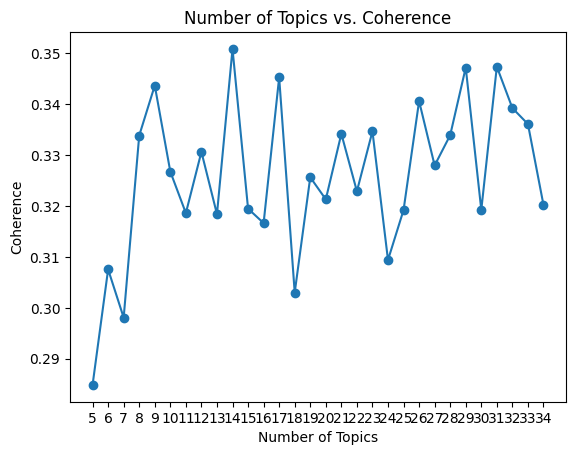

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

###LDA model with 20 topics

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=20, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [ ]:
# import pickle
# # Save as a pickle file
# with open('ldamodel20.pkl', 'wb') as f:
#     pickle.dump(ldamodel , f)

In [ ]:
import pickle
with open('ldamodel20.pkl', 'rb') as f:
    ldamodel = pickle.load(f)

In [ ]:
ldamodel.show_topics(20, num_words=10, formatted=False)

[(0,
  [('pause', 0.7421721),
   ('second', 0.058269862),
   ('thing', 0.0048152823),
   ('work', 0.004064097),
   ('time', 0.0038092192),
   ('year', 0.0034137599),
   ('way', 0.0026570861),
   ('lot', 0.0023999133),
   ('something', 0.0022932074),
   ('number', 0.0021276723)]),
 (1,
  [('school', 0.08850127),
   ('student', 0.045563683),
   ('year', 0.023867061),
   ('district', 0.023140235),
   ('board', 0.013022293),
   ('time', 0.010242182),
   ('education', 0.00982731),
   ('program', 0.009699206),
   ('work', 0.009648804),
   ('parent', 0.009506204)]),
 (2,
  [('work', 0.02764823),
   ('community', 0.025573676),
   ('thing', 0.01838376),
   ('question', 0.01405707),
   ('kind', 0.012429921),
   ('time', 0.012386446),
   ('way', 0.012149731),
   ('process', 0.012040702),
   ('thank', 0.011669946),
   ('talk', 0.010490397)]),
 (3,
  [('property', 0.049146757),
   ('plan', 0.027499957),
   ('use', 0.022063317),
   ('area', 0.021881739),
   ('development', 0.019940179),
   ('lot', 0

###Relevancy
Sometimes, words that are ranked as top words for a given topic may be ranked high because they are globally frequent across text in a corpus. Relevancy score helps to prioritize terms that belong more exclusively to a given topic. This can increase interpretability even more. The relevance of term w to topic k is defined as:

$ r(w,k| \lambda) = \lambda log(\phi_{kw}) +(1-\lambda)log(\frac{\phi_{kw}}{p_{kw}}) $

where $\phi_{kw}$ is the probability of term w in topic k and $\frac{\phi_{kw}}{p_{kw}}$ is lift in term's probability within a topic to its marginal probability across the corpus (this helps discards globally frequent terms).  A lower lambda value gives more importance to the second term, which gives more importance to topic exclusivity. We can use Python’s pyLDAvis for this. For example, when lowering lambda, we can see that topic 0 ranked terms that are even more relevant to the topic of hair salon service the highest.

Paper behind this tool: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [ ]:
# import pickle
# # Save as a pickle file
# with open('topic_data_20.pkl', 'wb') as f:
#     pickle.dump(topic_data , f)

In [ ]:
topic_data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds='pcoa', n_jobs=1)


In [ ]:
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim

# Assuming you already have 'topic_data' generated

# Extracting the topic information
topics_df = topic_data.topic_info

# Creating a pandas DataFrame from the topic information
topics_df = pd.DataFrame(topics_df)

# Display the topics DataFrame
print(topics_df)


           Term          Freq         Total Category  logprob  loglift
3426      pause  8.570726e+06  8.570726e+06  Default  30.0000  30.0000
190        city  2.568603e+06  2.568603e+06  Default  29.0000  29.0000
269     council  1.542440e+06  1.542440e+06  Default  28.0000  28.0000
1036     school  8.995130e+05  8.995130e+05  Default  27.0000  27.0000
1042     second  7.022310e+05  7.022310e+05  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
867      please  4.649396e+04  4.510772e+05  Topic15  -5.0830   1.0027
1173      thank  6.544426e+04  1.472610e+06  Topic15  -4.7412   0.1615
1268       work  6.204490e+04  1.760922e+06  Topic15  -4.7945  -0.0707
492        fund  4.695771e+04  6.668161e+05  Topic15  -5.0731   0.6218
221   community  4.675132e+04  1.118329e+06  Topic15  -5.0775   0.1003

[1440 rows x 6 columns]


In [ ]:
pyLDAvis.display(topic_data)


In [ ]:
all_topics = {}
num_terms = 15 # Adjust number of words to represent each topic
lambd = 0.2 # Adjust this accordingly based on tuning above
for i in range(1,21): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [ ]:
import pandas as pd
df = pd.DataFrame(all_topics).T
df

0             1             2            3   \
Topic 1           yeah         stuff           guy        thing   
Topic 2        housing        equity      strategy      transit   
Topic 3         budget       revenue          fund         debt   
Topic 4        council          city         mayor     glendale   
Topic 5       property          zone       density  subdivision   
Topic 6         motion         favor           aye          bid   
Topic 7          event         chino  proclamation     temecula   
Topic 8          water  intersection          pump      traffic   
Topic 9          pause        second           efe        bitch   
Topic 10          town         bylaw         music    selectman   
Topic 11       student        school       teacher    classroom   
Topic 12  commissioner        county          jail       health   
Topic 13      township  councilwoman    councilman       jersey   
Topic 14     endlinegt       officer        police         fire   
Topic 15      variance        garage     elevation         foot   
Topic 16          city      columbus           tif          cra   
Topic 17    councillor     counselor         sioux    councilor   
Topic 18       license        liquor    restaurant      alcohol   
Topic 19      alderman      evanston         alder       renton   
Topic 20       village       trustee        asbury          dog   

                     4              5               6   \
Topic 1             get      something        somebody   
Topic 2    homelessness      community          eugene   
Topic 3        increase            tax            rate   
Topic 4   mayor_pro_tem  councilmember      california   
Topic 5            acre         rezone          parcel   
Topic 6           carry           item      discussion   
Topic 7          museum       thornton     celebration   
Topic 8            lane          storm            pipe   
Topic 9      warehouser      salvatore         mancini   
Topic 10          board      committee         article   
Topic 11         parent     curriculum  superintendent   
Topic 12     supervisor        sheriff         vaccine   
Topic 13      montclair            nan         borough   
Topic 14          chief          crime          patrol   
Topic 15          space           roof          window   
Topic 16         albion         dublin      cloverdale   
Topic 17         durham        jamison     albuquerque   
Topic 18       business        tobacco   establishment   
Topic 19        batavia      brentwood          geneva   
Topic 20       bartlett       tuckahoe          trusty   

                                7           8            9              10  \
Topic 1                       kind  everything         mean           talk   
Topic 2                       goal  engagement   burlington  affordability   
Topic 3                     dollar     capital  expenditure        percent   
Topic 4                      bruno      member      manager        burbank   
Topic 5                       land  annexation  development      developer   
Topic 6                     bidder      agenda     contract       approval   
Topic 7                 portsmouth    festival     applause            art   
Topic 8                      trail     project     sidewalk      crosswalk   
Topic 9                  northport  eversource     astorino       brocklin   
Topic 10                   fairfax   hampshire        essex        meeting   
Topic 11                enrollment   education     educator          grade   
Topic 12                    inmate  courthouse     calavera       hospital   
Topic 13                hackensack   president        akron          lanse   
Topic 14                department    dispatch     incident    firefighter   
Topic 15                 architect     setback      bedroom       building   
Topic 16                 twinsburg  bellflower        yukon           tiff   
Topic 17                   jameson      casper     homewood       e

In [ ]:
import pickle
with open('final_df.pkl', 'rb') as f:
    final_df = pickle.load(f)
final_df

state_name  year                                 caption_text_clean
0          Texas  2006  [city, council, city, league, city, meeting, n...
1          Texas  2006  [everybody, city, council, city, council, twen...
2          Texas  2006  [honor, afternoon, call, order, city, council,...
3          Texas  2006  [afternoon, call, city, council, city, city, c...
4          Texas  2006  [afternoon, call, order, city, council, city, ...
...          ...   ...                                                ...
99185    Wyoming  2018  [call, medicine, ball, call, pause, council, m...
99186    Wyoming  2018  [pause, resolution, city, pause, attorney, som...
99187    Wyoming  2018  [council, direction, regard, pause, plain, cou...
99188    Wyoming  2018  [change, agenda, fun, watch, guy, letter, yeah...
99189        NaN  2018  [community, amendment, contract, place, woman,...

[99190 rows x 3 columns]

In [ ]:
from tqdm import tqdm

topic_names = [
    "Unclear Topic",  # 0
    "Housing", #1
    "Budget and Financial Management", #2
    "City Council and Government Operations", #3 ??
    "Real estate and development", #4
    "Meeting Motions and Procedures", #5
    "Community Events and Celebrations", #6
    "Water Infrastructure and Projects", #7
    "Unclear Topic", #8 ?
    "Town Bylaws and Committees", #9
    "Education", #10
    "Law Enforcement and Public Health",  #11
    "Township and Local Governance", #12 ?
    "Law Enforcement and Public Safety", #13
    "Architecture and construction", #14
    "City and Urban Development", #15?
    "Local Councilors and Representatives", #16
    "Licensing and Business Regulations", #17
    "Aldermen and Local Government", #18
    "Animals" #19
]

# Get the topic distribution for each document with tqdm
topic_assignments = []
top_topics = []
topic_names_assigned = []

for topic_dist in tqdm(ldamodel[doc_term_matrix], total=len(doc_term_matrix), desc="Assigning Topics"):
    topic_dist_sorted = sorted(topic_dist, key=lambda item: item[1], reverse=True)

    if len(topic_dist_sorted) >= 1:
        max_topic = topic_dist_sorted[0][0]
    else:
        max_topic = 0  # Assigning the "Unclear Topic"

    topic_assignments.append(max_topic)
    top_topics.append(topic_dist_sorted)
    topic_names_assigned.append(topic_names[max_topic])

# Assign topic number, topic distribution, and topic name to each row in the DataFrame
final_df['topic'] = topic_assignments
final_df['topic_dist_sorted'] = top_topics
final_df['topic_name'] = topic_names_assigned



Assigning Topics: 100%|██████████| 99190/99190 [09:09<00:00, 180.50it/s] 


In [ ]:
final_df

state_name  year                                 caption_text_clean  \
0          Texas  2006  [city, council, city, league, city, meeting, n...   
1          Texas  2006  [everybody, city, council, city, council, twen...   
2          Texas  2006  [honor, afternoon, call, order, city, council,...   
3          Texas  2006  [afternoon, call, city, council, city, city, c...   
4          Texas  2006  [afternoon, call, order, city, council, city, ...   
...          ...   ...                                                ...   
99185    Wyoming  2018  [call, medicine, ball, call, pause, council, m...   
99186    Wyoming  2018  [pause, resolution, city, pause, attorney, som...   
99187    Wyoming  2018  [council, direction, regard, pause, plain, cou...   
99188    Wyoming  2018  [change, agenda, fun, watch, guy, letter, yeah...   
99189        NaN  2018  [community, amendment, contract, place, woman,...   

       topic                              topic_name  \
0         12           Township and Local Governance   
1         12           Township and Local Governance   
2          3  City Council and Government Operations   
3         12           Township and Local Governance   
4          3  City Council and Government Operations   
...      ...                                     ...   
99185      0                           Unclear Topic   
99186      0                           Unclear Topic   
99187      0                           Unclear Topic   
99188      0                           Unclear Topic   
99189     11       Law Enforcement and Public Health   

                                       topic_dist_sorted  
0      [(12, 0.2119146), (13, 0.14742106), (4, 0.1454...  
1      [(12, 0.38744932), (4, 0.14508633), (7, 0.1167...  
2      [(3, 0.20749885), (17, 0.1611654), (12, 0.1477...  
3      [(12, 0.22087374), (3, 0.12890132), (17, 0.120...  
4      [(3, 0.44708535), (19, 0.1666868), (12, 0.1293...  
...                                                  ...  
99185  [(0, 0.3090208), (17, 0.18821101), (7, 0.17581...  
99186  [(0, 0.39315385), (17, 0.20475274), (12, 0.195...  
99187  [(0, 0.3233611), (17, 0.14509024), (15, 0.0894...  
99188  [(0, 0.2943183), (12, 0.1883202), (17, 0.10774...  
99189  [(11, 0.39580184), (2, 0.196282), (17, 0.17948...  

[99190 rows x 6 columns]

###Word Cloud for each Topic

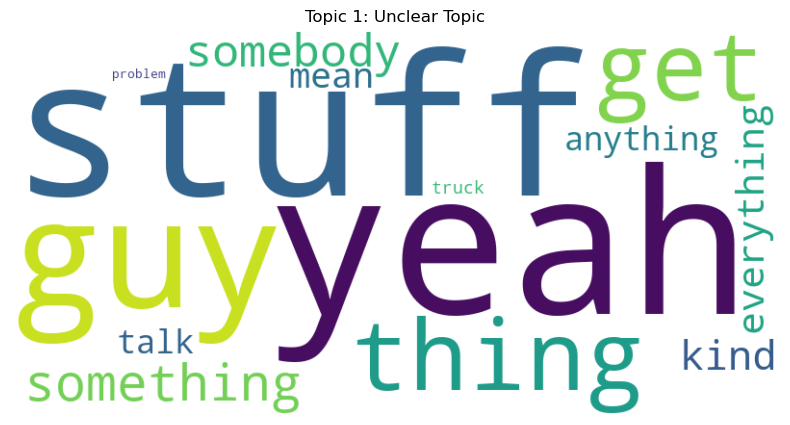

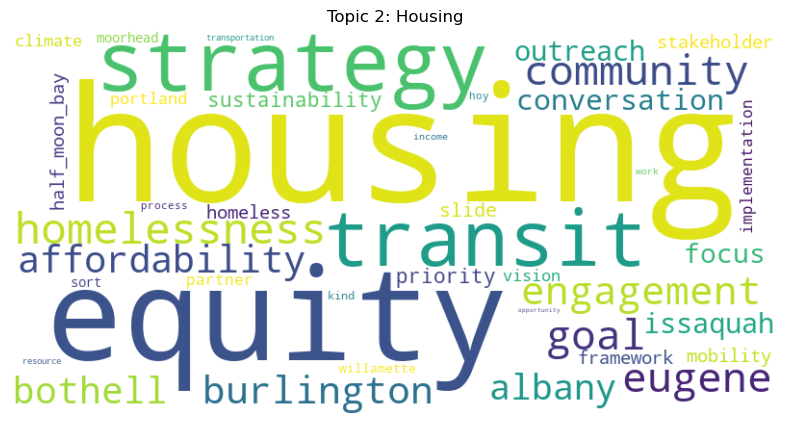

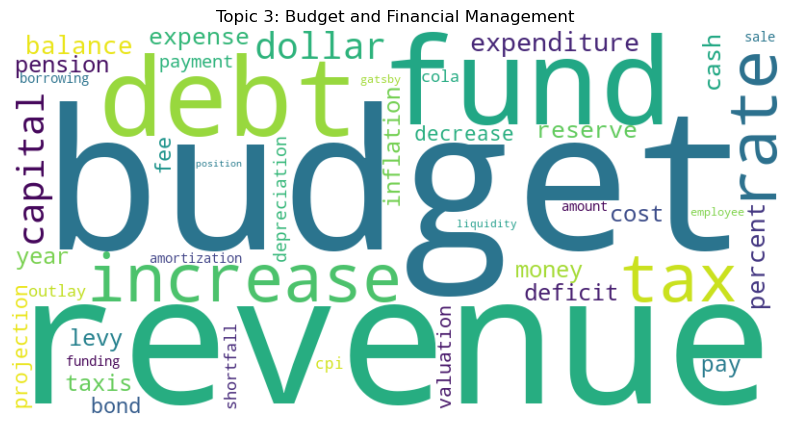

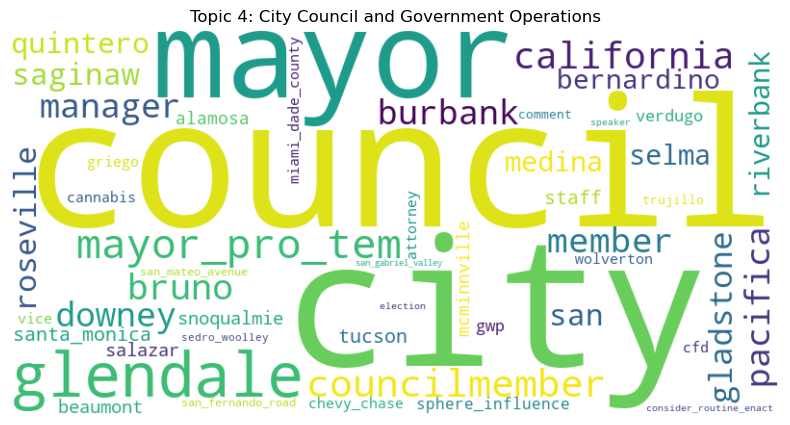

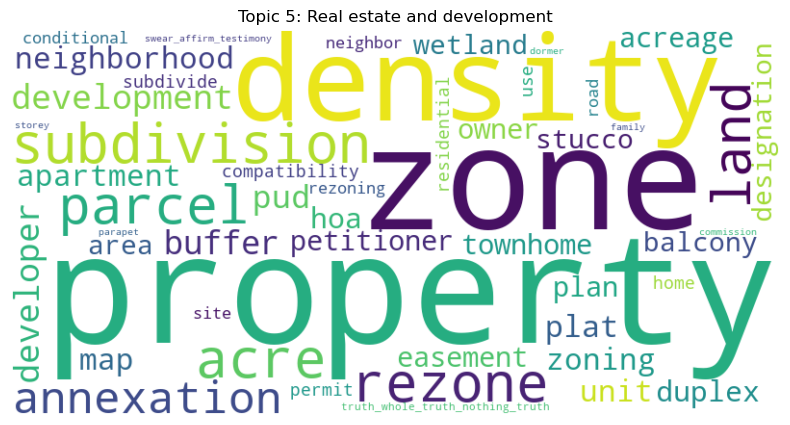

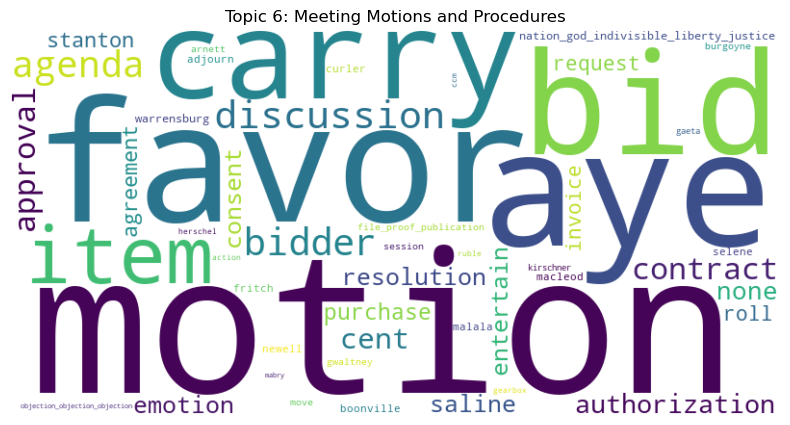

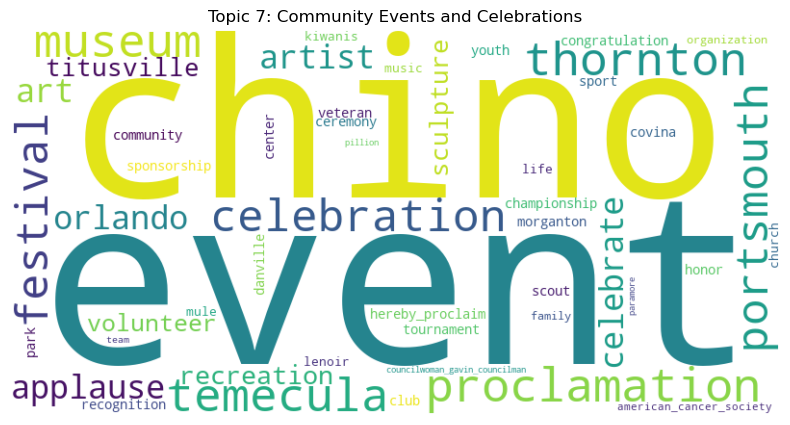

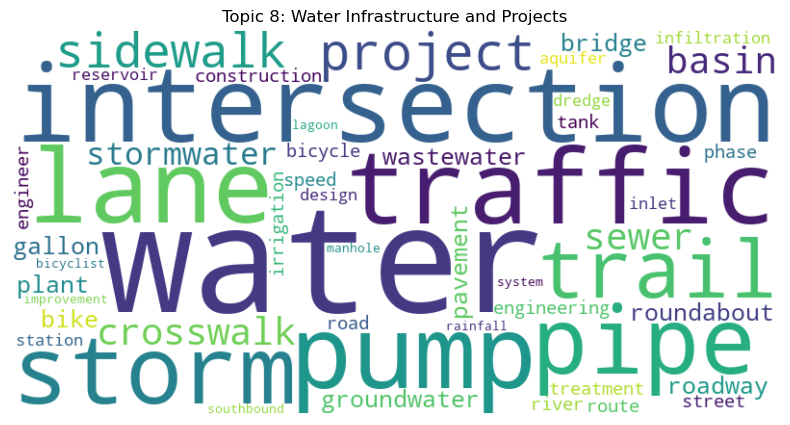

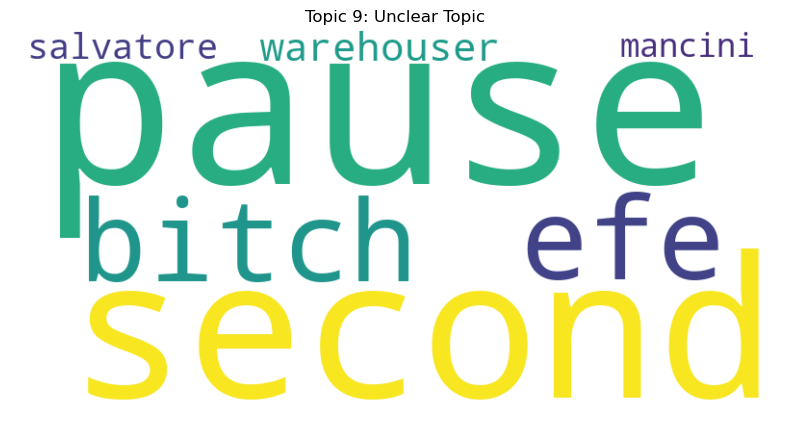

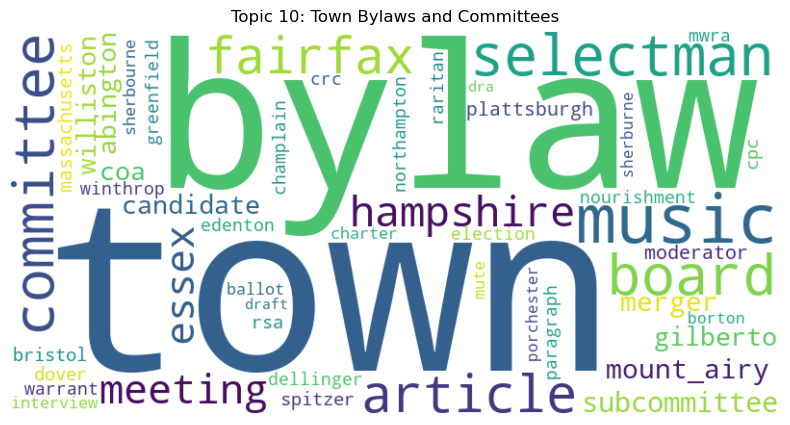

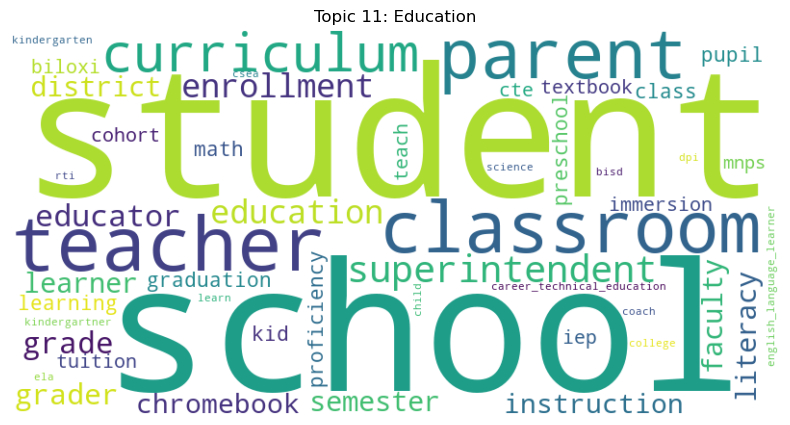

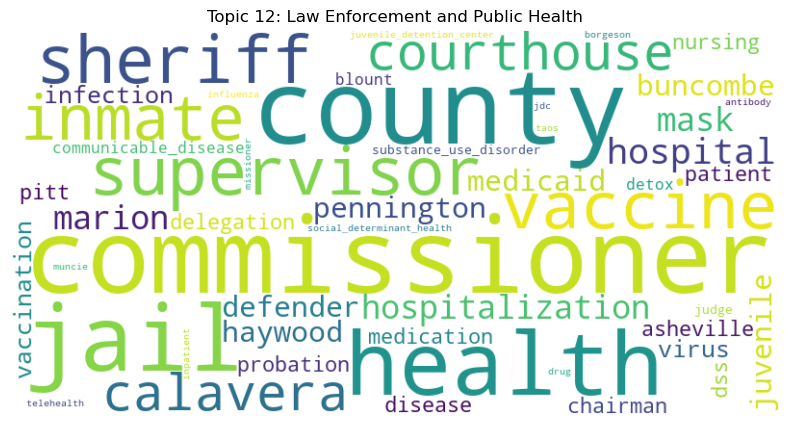

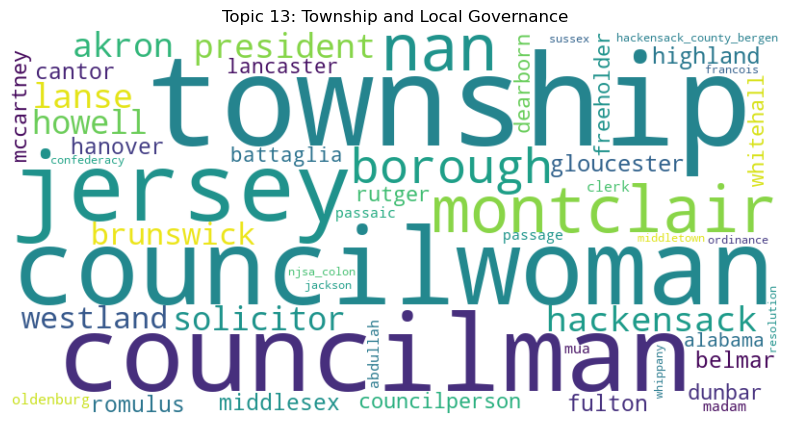

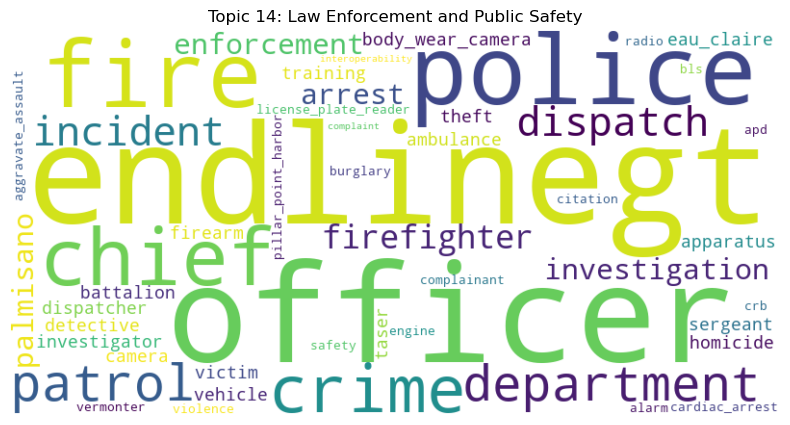

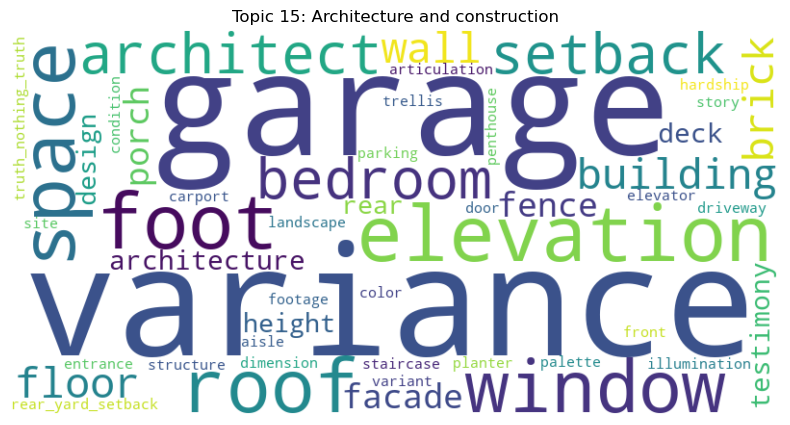

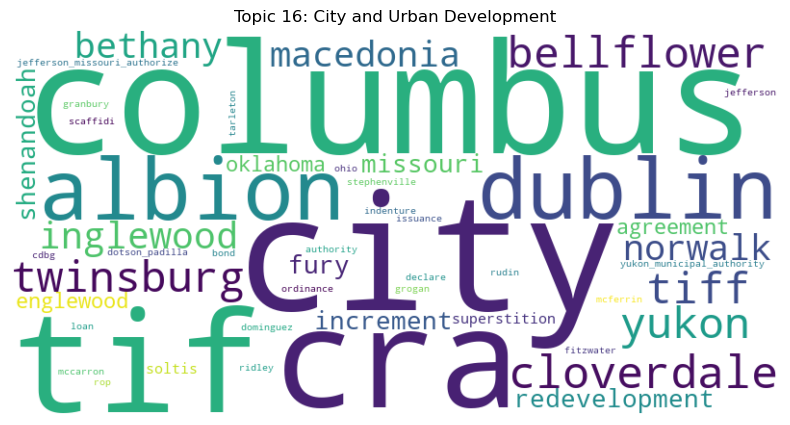

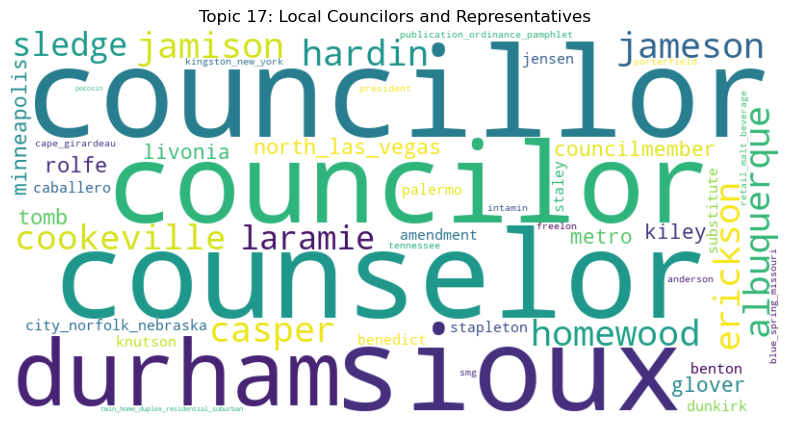

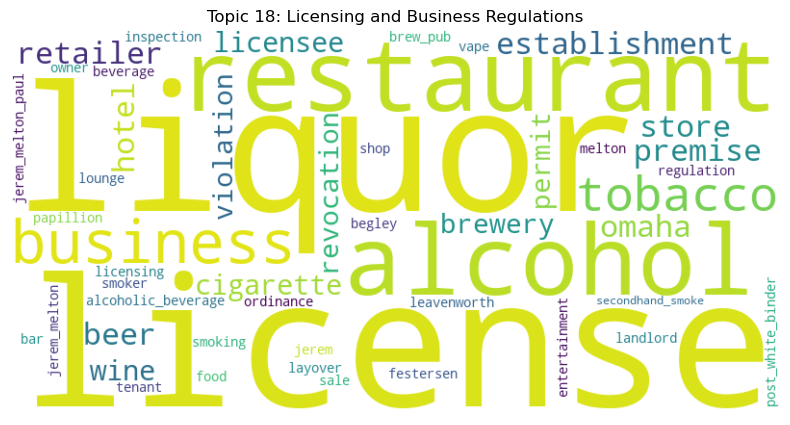

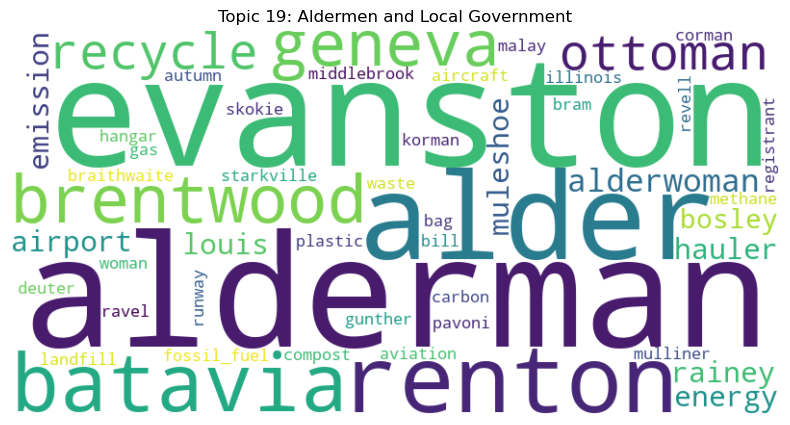

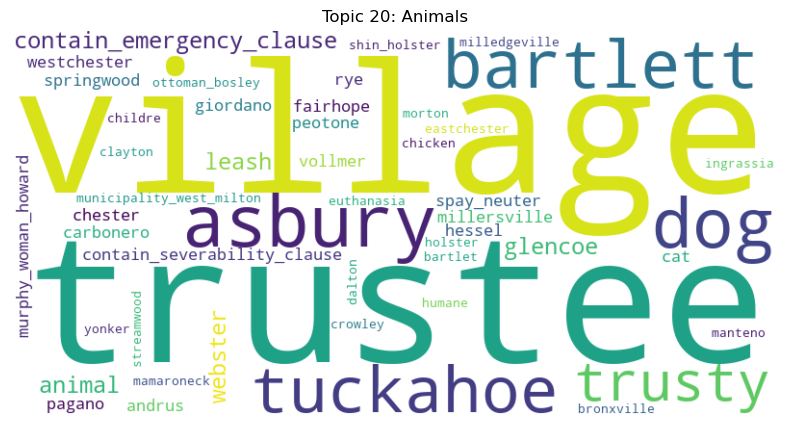

In [ ]:
all_topics = {}
num_terms = 50
lambd = 0.2

for i in range(1, 21):
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic' + str(i)].copy()
    topic['relevance'] = topic['loglift'] * (1 - lambd) + topic['logprob'] * lambd
    topic = topic.sort_values(by='relevance', ascending=False)

    # Extract terms and relevance scores
    terms = topic.Term[:num_terms].values
    relevance_scores = topic.relevance[:num_terms].values

    # Create a dictionary with terms and their relevance scores
    term_relevance = {term: score for term, score in zip(terms, relevance_scores)}

    all_topics['Topic ' + str(i)] = term_relevance


import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create word clouds for each topic's terms
for i, (topic, term_relevance) in enumerate( all_topics.items()):
    # Filter out negative relevance scores
    term_relevance_positive = {term: score for term, score in term_relevance.items() if score > 0}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_relevance_positive)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(str(topic)+": "+topic_names[i])
    plt.axis('off')
    plt.show()

###Temporal Evolution for Topic

In [ ]:
final_df

state_name  year                                 caption_text_clean  \
0          Texas  2006  [city, council, city, league, city, meeting, n...   
1          Texas  2006  [everybody, city, council, city, council, twen...   
2          Texas  2006  [honor, afternoon, call, order, city, council,...   
3          Texas  2006  [afternoon, call, city, council, city, city, c...   
4          Texas  2006  [afternoon, call, order, city, council, city, ...   
...          ...   ...                                                ...   
99185    Wyoming  2018  [call, medicine, ball, call, pause, council, m...   
99186    Wyoming  2018  [pause, resolution, city, pause, attorney, som...   
99187    Wyoming  2018  [council, direction, regard, pause, plain, cou...   
99188    Wyoming  2018  [change, agenda, fun, watch, guy, letter, yeah...   
99189        NaN  2018  [community, amendment, contract, place, woman,...   

       topic                                  topic_dist_sorted  
0         12  [(12, 0.21190785), (13, 0.1474196), (4, 0.1454...  
1         12  [(12, 0.3874515), (4, 0.1450889), (7, 0.116761...  
2          3  [(3, 0.20749867), (17, 0.16116574), (12, 0.147...  
3         12  [(12, 0.22087355), (3, 0.12890133), (17, 0.120...  
4          3  [(3, 0.44708472), (19, 0.16668592), (12, 0.129...  
...      ...                                                ...  
99185      0  [(0, 0.3090207), (17, 0.18821084), (7, 0.17581...  
99186      0  [(0, 0.39315182), (17, 0.20476323), (12, 0.195...  
99187      0  [(0, 0.32336113), (17, 0.14508997), (15, 0.089...  
99188      0  [(0, 0.2943186), (12, 0.18831658), (17, 0.1077...  
99189     11  [(11, 0.39580262), (2, 0.1962827), (17, 0.1794...  

[99190 rows x 5 columns]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to store topic assignments and years
topic_df = final_df[['year', 'topic']].copy()
topic_df['count'] = 1

# Group by year and topic and calculate the counts
grouped_df = topic_df.groupby(['year', 'topic']).count().reset_index()

# Calculate total counts for each year
total_counts = topic_df.groupby('year').count().reset_index()

# Merge the total counts with the grouped DataFrame
grouped_df = grouped_df.merge(total_counts, on='year', suffixes=('_topic', '_total'))

# Calculate the relative count
grouped_df['relative_count'] = grouped_df['count_topic'] / grouped_df['count_total']


In [ ]:
grouped_df


year  topic_topic  count_topic  topic_total  count_total  relative_count
0    2006            3            2            9            9        0.222222
1    2006            4            1            9            9        0.111111
2    2006           12            5            9            9        0.555556
3    2006           17            1            9            9        0.111111
4    2007            0            2           12           12        0.166667
..    ...          ...          ...          ...          ...             ...
291  2022           15           64        10308        10308        0.006209
292  2022           16          153        10308        10308        0.014843
293  2022           17         1871        10308        10308        0.181510
294  2022           18          455        10308        10308        0.044140
295  2022           19          688        10308        10308        0.066744

[296 rows x 6 columns]

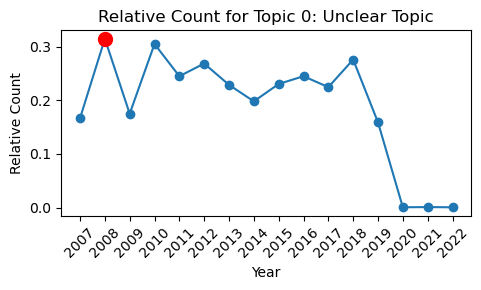

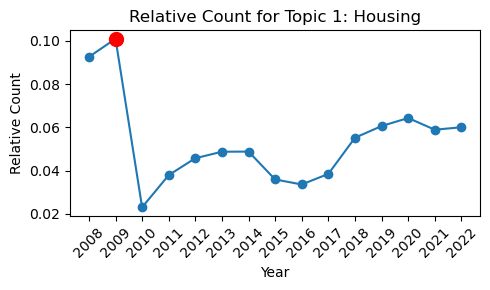

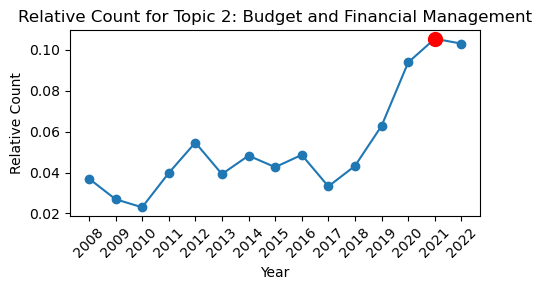

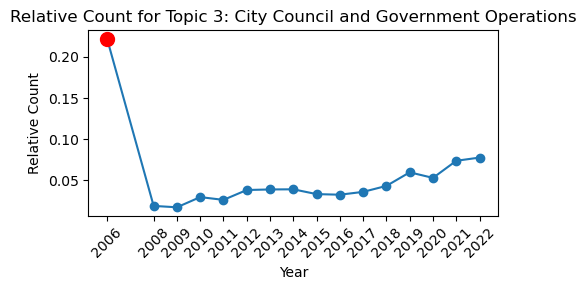

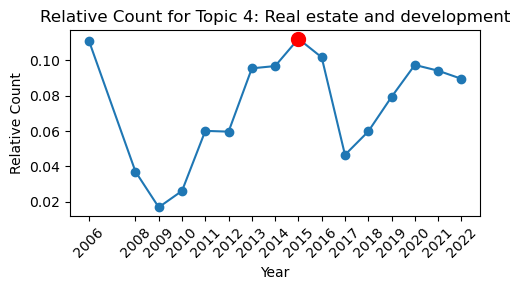

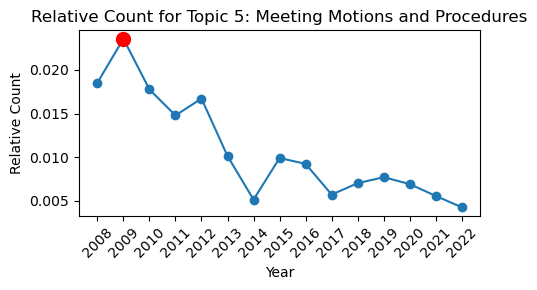

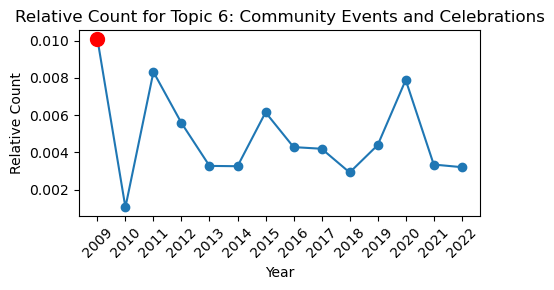

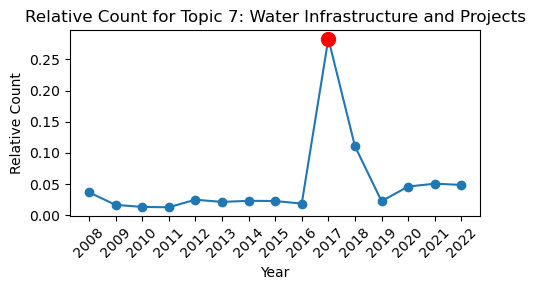

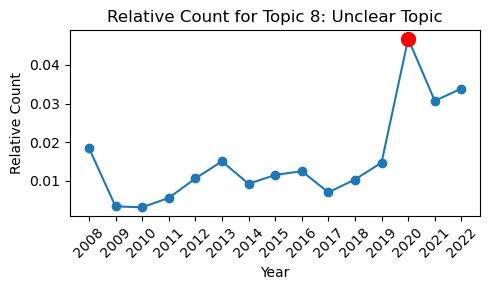

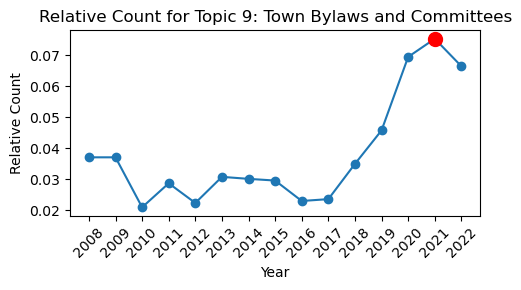

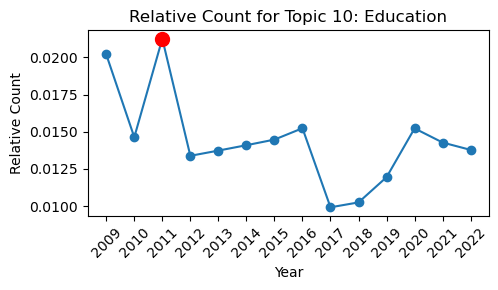

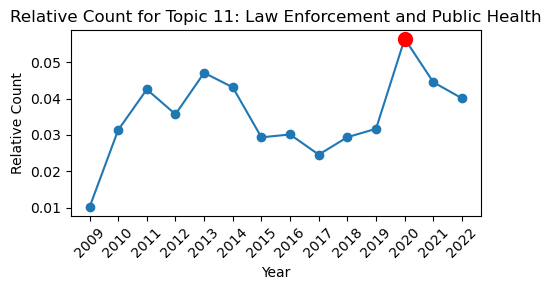

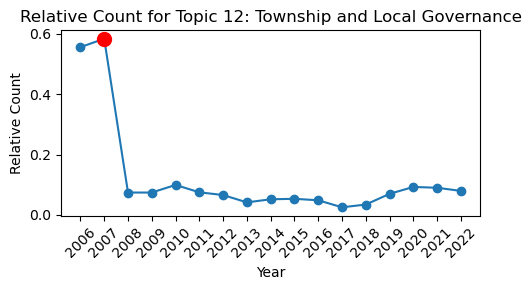

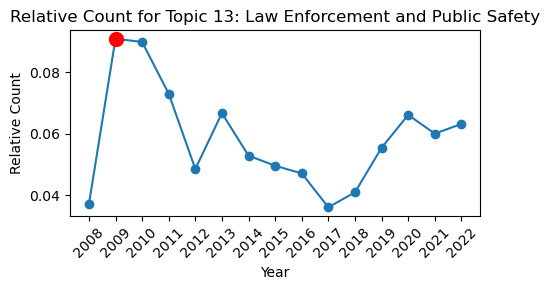

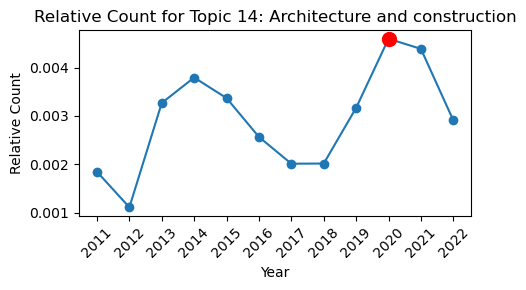

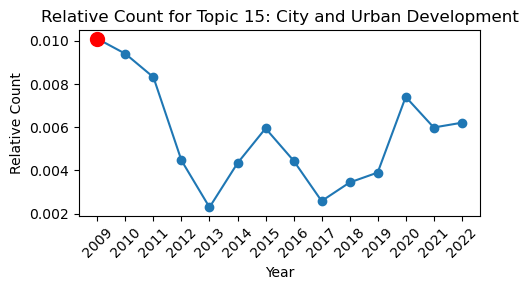

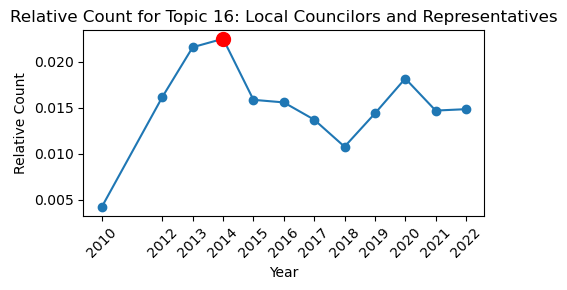

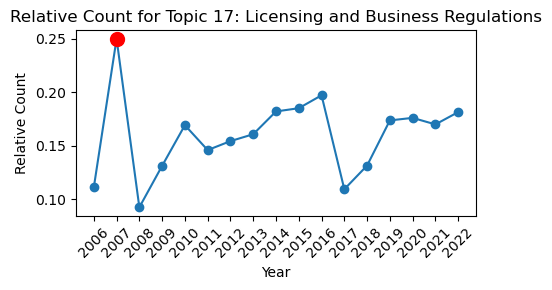

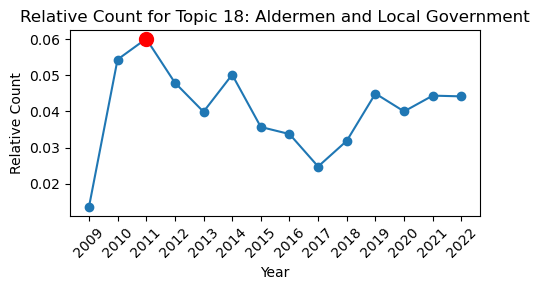

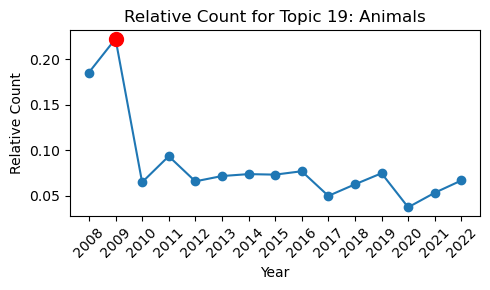

In [ ]:
# Create line plots for each topic

for topic in range(0,20):
    topic_data = grouped_df[grouped_df['topic_topic'] == topic]

    # Find the index of the highest relative count
    max_index = topic_data['relative_count'].idxmax()

    plt.figure(figsize=(5, 3))
    plt.plot(topic_data['year'], topic_data['relative_count'], marker='o')

    # Mark the highest point with a red big point
    plt.plot(topic_data.loc[max_index, 'year'], topic_data.loc[max_index, 'relative_count'], 'ro', markersize=10)

    plt.title(f'Relative Count for Topic {topic}: '+topic_names[topic])
    plt.xlabel('Year')
    plt.ylabel('Relative Count')

    # Show all years on x-axis
    plt.xticks(topic_data['year'], rotation=45)

    plt.tight_layout()
    plt.show()


##Equality

In [ ]:
final_df['equality'] = final_df['caption_text_clean'].apply(lambda tokens: tokens.count('equality'))

In [ ]:
final_df['equality'] = final_df['equality'] / final_df['caption_text_clean'].apply(len)

In [ ]:
import math
# Apply natural logarithm to the 'equality' column with a small constant added
final_df['equality'] = final_df['equality'].apply(lambda x: -math.log(x + 1e-6) if x > 0 else 0)

In [ ]:
yearly_equality_counts = final_df.groupby('year')['equality'].agg(equality_sum='sum', total_rows='count')
yearly_equality_counts = yearly_equality_counts.reset_index()
yearly_equality_counts

year  equality_sum  total_rows
0   2006      0.000000           9
1   2007      0.000000          12
2   2008      6.715769          54
3   2009      5.978491         297
4   2010     44.800292         957
5   2011    105.412474        1082
6   2012    154.052372        1794
7   2013    392.570197        3059
8   2014    297.247377        3690
9   2015    445.305618        5045
10  2016    564.275336        5842
11  2017   1949.699345       12408
12  2018   2356.381501       13376
13  2019   2904.771767       12311
14  2020   3689.580644       14582
15  2021   4090.074679       14364
16  2022   3367.873024       10308

In [ ]:
# Calculate the average racial count per row for each year
yearly_equality_counts['average_equality_count'] = yearly_equality_counts['equality_sum'] / yearly_equality_counts['total_rows']
yearly_equality_counts


year  equality_sum  total_rows  average_equality_count
0   2006      0.000000           9                0.000000
1   2007      0.000000          12                0.000000
2   2008      6.715769          54                0.124366
3   2009      5.978491         297                0.020130
4   2010     44.800292         957                0.046813
5   2011    105.412474        1082                0.097424
6   2012    154.052372        1794                0.085871
7   2013    392.570197        3059                0.128333
8   2014    297.247377        3690                0.080555
9   2015    445.305618        5045                0.088267
10  2016    564.275336        5842                0.096589
11  2017   1949.699345       12408                0.157132
12  2018   2356.381501       13376                0.176165
13  2019   2904.771767       12311                0.235949
14  2020   3689.580644       14582                0.253023
15  2021   4090.074679       14364                0.284745
16  2022   3367.873024       10308                0.326724

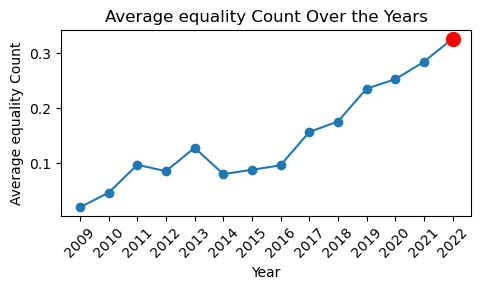

In [ ]:
import matplotlib.pyplot as plt

# Filter out the year 2006
yearly_equality_counts_filtered = yearly_equality_counts[yearly_equality_counts['year'] > 2008]

# Create a line plot
plt.figure(figsize=(5, 3))
plt.plot(yearly_equality_counts_filtered['year'], yearly_equality_counts_filtered['average_equality_count'], marker='o')

# Mark the highest point with a red big point
max_index = yearly_equality_counts_filtered['average_equality_count'].idxmax()
plt.plot(yearly_equality_counts_filtered.loc[max_index, 'year'], yearly_equality_counts_filtered.loc[max_index, 'average_equality_count'], 'ro', markersize=10)

plt.title('Average equality Over the Years')
plt.xlabel('Year')
plt.ylabel('Average equality Count')

# Show all years on x-axis
plt.xticks(yearly_equality_counts_filtered['year'], rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Group the DataFrame by 'year', calculate the sum of 'racial_count', and count the total rows in each group
yearly_state_equality_counts = final_df.groupby(['year','state_name'])['equality'].agg(equality_sum='sum', total_rows='count')
yearly_state_equality_counts = yearly_state_equality_counts.reset_index()
yearly_state_equality_counts

year      state_name  equality_sum  total_rows
0    2006           Texas      0.000000           9
1    2007         Alabama      0.000000           3
2    2007      California      0.000000           2
3    2007  South Carolina      0.000000           1
4    2007           Texas      0.000000           6
..    ...             ...           ...         ...
559  2022        Virginia     72.243673         209
560  2022      Washington    117.550193         351
561  2022   West Virginia     16.472141          28
562  2022       Wisconsin     99.908490         317
563  2022         Wyoming      8.351370          19

[564 rows x 4 columns]

In [ ]:
import pandas as pd
yearly_state_equality_counts = pd.read_csv('/content/df_map.csv')



In [ ]:
# Group the DataFrame by 'state_name' and a custom range of years
# You can adjust the range of years as needed
year_ranges = [(2005, 2008), (2009, 2013), (2014, 2018), (2019, 2022)]
results = []

for start_year, end_year in year_ranges:
    year_range_df = yearly_state_equality_counts[(yearly_state_equality_counts['year'] >= start_year) & (yearly_state_equality_counts['year'] <= end_year)]
    grouped = year_range_df.groupby('state_name')['equality_sum'].sum().reset_index()
    grouped['year_range'] = f"{start_year}-{end_year}"
    results.append(grouped)

# Combine the results into a single DataFrame
result_df = pd.concat(results, ignore_index=True)

# Display the result DataFrame
result_df


state_name  equality_sum year_range
0          Alabama      0.000000  2005-2008
1         Arkansas      0.000000  2005-2008
2       California      6.715769  2005-2008
3         Illinois      0.000000  2005-2008
4        Minnesota      0.000000  2005-2008
..             ...           ...        ...
141       Virginia    255.640882  2019-2022
142     Washington    619.285398  2019-2022
143  West Virginia     16.472141  2019-2022
144      Wisconsin    381.936116  2019-2022
145        Wyoming     60.797552  2019-2022

[146 rows x 3 columns]

In [ ]:
max(result_df['equality_sum'])

2621.639766789658

In [ ]:
import folium
from folium.plugins import TimestampedGeoJson
from geopy.geocoders import Nominatim

# Create a geocoder instance
geolocator = Nominatim(user_agent="equity_sum_mapping")

def data_map(df):
    # Prepare the data for TimestampedGeoJson
    data = []

    # year_data = df0[df0['year'] == year]
    year_features = []

    for index, row in df.iterrows():
        state_name = row['state_name']
        equity_sum = row['equality_sum']
        try:
            location = geolocator.geocode(state_name + ', USA')  # Add ', USA' to ensure accurate state results
            latitude = location.latitude
            longitude = location.longitude
            year_features.append(
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": [longitude, latitude]
                    },
                    "properties": {
                        "popup": f"{state_name}: {equity_sum}"
                    }
                }
            )
        except:
            pass

    data.append(year_features)
    return data

data0 = data_map(results[0])
data1 = data_map(results[1])
data2 = data_map(results[2])
data3 = data_map(results[3])

### Temporal Visualization of Equity Scores in U.S. State Maps

#### 2009-2013

In [ ]:
base_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5,  tiles='Stamen Terrain')

for feature in data1:
    for i in feature:
      coordinates = i['geometry']['coordinates']
      equity_sum = i['properties']['popup'].split(': ')[1]
      state_name = i['properties']['popup'].split(': ')[0]
      # print(i)
      tooltip = state_name+" Score: "+equity_sum
      folium.CircleMarker(
          location=[coordinates[1], coordinates[0]],
          radius=int(float(equity_sum) / 10),
          color='blue',
          fill=True,
          fill_opacity=0.6,
          tooltip=tooltip
      ).add_to(base_map)
# Display the map
base_map


In [ ]:
base_map.save("us_map.html")

#### 2014-2018

In [ ]:
base_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5  ,tiles='Stamen Terrain')

for feature in data2:
    for i in feature:
      coordinates = i['geometry']['coordinates']
      equity_sum = i['properties']['popup'].split(': ')[1]
      state_name = i['properties']['popup'].split(': ')[0]
      # print(i)
      tooltip = state_name+" Score: "+equity_sum
      print(float(equity_sum))
      folium.CircleMarker(
          location=[coordinates[1], coordinates[0]],
          radius=int(float(equity_sum) / 10),
          color='blue',
          fill=True,
          fill_opacity=0.6,
          tooltip=tooltip
      ).add_to(base_map)
# Display the map
base_map


121.65724576409508
0.0
68.68336893817316
15.445319609399512
439.2039839878549
31.545103300640935
0.0
96.63832717317433
22.866403524427078
7.985600316629629
366.0847053383295
4.875066331780903
55.53353427943062
53.70767604949273
21.899092300162522
0.0
8.493117362319602
0.0
177.63372941952792
424.30233880348135
213.00892761721843
19.73024820797671
230.64125524185368
30.530668231729475
37.58460373495574
31.352091368964018
88.23225724340509
232.9808763608538
97.56825159688006
145.22275894185927
290.30158036719473
0.0
309.9544064662041
84.2598586862947
380.74708763803505
99.66142097251362
52.78138456844889
14.717077403733189
328.7045875761044
86.54859610850949
216.31372997417128
37.269233511415685
48.74537363522726
187.33565469169616
245.346626547752
0.0
99.94698329135255
86.86902519931039


#### 2018-2022

In [ ]:
base_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4.5,  tiles='Stamen Terrain')

for feature in data3:
    for i in feature:
      coordinates = i['geometry']['coordinates']
      equity_sum = i['properties']['popup'].split(': ')[1]
      state_name = i['properties']['popup'].split(': ')[0]
      print(int(float(equity_sum)))
      print(equity_sum)
      tooltip = state_name+" Score: "+equity_sum
      folium.CircleMarker(
          location=[coordinates[1], coordinates[0]],
          radius=int(float(equity_sum)/20),
          color='blue',
          fill=True,
          fill_opacity=0.6,
          tooltip=tooltip
      ).add_to(base_map)
# Display the map
base_map


354
354.1498245467791
0
0.0
111
111.54537676770491
23
23.356955592985322
2621
2621.639766789658
186
186.35893158851604
73
73.09885512812741
230
230.85475631410887
113
113.64599571479594
37
37.37403039571161
630
630.884763590401
0
0.0
110
110.41085548414745
65
65.49877415429297
15
15.550953015530837
0
0.0
88
88.37506879480667
0
0.0
426
426.5250567484885
740
740.7277882508488
383
383.97984257256786
77
77.82408780570776
381
381.7027061578163
18
18.021510954790074
181
181.5588849506898
57
57.41582520966971
52
52.70374176667075
769
769.0115002381065
122
122.1037834727626
280
280.6021453771094
1181
1181.6817521500632
516
516.9161628193297
225
225.09722156386516
757
757.9388750295323
225
225.540330137328
23
23.01043703233017
76
76.39955824227222
292
292.89600349413683
526
526.270507957909
306
306.9566777268607
92
92.54769216229923
337
337.9910254058541
255
255.64088236832694
619
619.2853978396913
16
16.472141112203794
381
381.9361159808434
60
60.79755164476026
